In [1]:
import numpy as np 
import pandas as pd 
import os
print(os.listdir("Desktop/ml/dogvscat"))

['train', 'test', 'sample_submission.csv']


In [2]:
import cv2                 
import numpy as np         
import os                  
from random import shuffle
from tqdm import tqdm      

train_dir = 'Desktop/ml/dogvscat/train'
test_dir = 'Desktop/ml/dogvscat/test'

In [3]:
def get_label(img):
    label = img.split('.')[0]
    if label == 'cat': 
        return [1,0]
    elif label == 'dog': 
        return [0,1]


In [4]:
def making_train_data():
    training_data = []
    
    for img in tqdm(os.listdir(train_dir)):
        label = get_label(img)
        path = os.path.join(train_dir,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (50,50))
        training_data.append([np.array(img),np.array(label)])
        
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data


In [5]:
def making_test_data():
    testing_data = []
    
    for img in tqdm(os.listdir(test_dir)):
        path = os.path.join(test_dir , img)
        img_num = img.split('.')[0]
        img = cv2.imread(path , cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img , (50,50))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [6]:
train_data = making_train_data()


100%|██████████| 25000/25000 [00:29<00:00, 856.19it/s]


In [7]:
import numpy
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

Using TensorFlow backend.


In [8]:
train = train_data[0:20000]
test = train_data[20000:25000]


In [9]:
print(len(train) , len(test))


20000 5000


In [10]:
X = np.array([i[0] for i in train]).reshape(-1,1,50,50)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,1,50,50)
test_y = [i[1] for i in test]


In [11]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.0,  
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=False, 
        vertical_flip=False)  

datagen.fit(X)

In [12]:
from keras.callbacks import ReduceLROnPlateau
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)


/home/timtim/anaconda3/envs/tf36/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [13]:
Y = np.asarray(Y)
Y.reshape(len(Y) , 2)


array([[1, 0],
       [1, 0],
       [0, 1],
       ...,
       [1, 0],
       [0, 1],
       [1, 0]])

In [14]:
test_y = np.asarray(test_y)
test_y.reshape(len(test_y) , 2)

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [15]:
test_x = test_x.reshape(-1, 1, 50, 50)

In [16]:
test_x = test_x / 255
X = X / 255

In [17]:
X.shape

(20000, 1, 50, 50)

In [18]:
from keras.layers import Dense , Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

In [19]:
def swish_activation(x):
    '''
    Keras implementation of swish https://arxiv.org/abs/1710.05941
    '''
    return (K.sigmoid(x) * x)

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(1,50,50)))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation=swish_activation))
model.add(Dropout(0.4))
model.add(Dense(2 , activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 50, 50)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 50, 50)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 25, 25)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 25, 25)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 25, 25)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 12, 12)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 96, 12, 12)        55392     
__________

In [20]:
batch_size = 128
epochs = 20


model.compile(loss='binary_crossentropy', optimizer='adam' , metrics=['accuracy'])
steps_per_epoch = len(train_data) // batch_size
validation_steps = len((test_x, test_y)) // batch_size

In [21]:
history = model.fit_generator(datagen.flow(X, Y, batch_size=batch_size),
                    steps_per_epoch=X.shape[0] // batch_size,
                    callbacks=[lr_reduce],
                    validation_data=(test_x, test_y),
                    epochs = epochs, verbose = 2)

Epoch 1/20
 - 578s - loss: 0.6912 - acc: 0.5177 - val_loss: 0.6834 - val_acc: 0.5295
Epoch 2/20
 - 574s - loss: 0.6715 - acc: 0.5872 - val_loss: 0.6972 - val_acc: 0.5721
Epoch 3/20
 - 574s - loss: 0.6327 - acc: 0.6470 - val_loss: 0.5805 - val_acc: 0.6953
Epoch 4/20
 - 575s - loss: 0.5681 - acc: 0.7101 - val_loss: 0.5443 - val_acc: 0.7157
Epoch 5/20
 - 575s - loss: 0.5160 - acc: 0.7474 - val_loss: 0.4933 - val_acc: 0.7668
Epoch 6/20
 - 575s - loss: 0.4648 - acc: 0.7791 - val_loss: 0.4088 - val_acc: 0.8057
Epoch 7/20
 - 574s - loss: 0.4188 - acc: 0.8112 - val_loss: 0.3993 - val_acc: 0.8036

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 8/20
 - 570s - loss: 0.3662 - acc: 0.8367 - val_loss: 0.3815 - val_acc: 0.8196
Epoch 9/20
 - 570s - loss: 0.3547 - acc: 0.8444 - val_loss: 0.3794 - val_acc: 0.8254
Epoch 10/20
 - 570s - loss: 0.3503 - acc: 0.8464 - val_loss: 0.3713 - val_acc: 0.8287
Epoch 11/20
 - 570s - loss: 0.3445 - acc: 0.8484 - val_loss: 0.3641

In [22]:
score = model.evaluate(test_x, test_y, verbose=0)
print('valid loss:', score[0])
print('valid accuracy:', score[1])

valid loss: 0.3661929356575012
valid accuracy: 0.8328


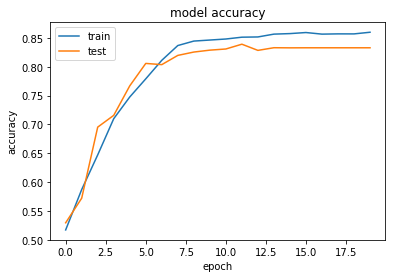

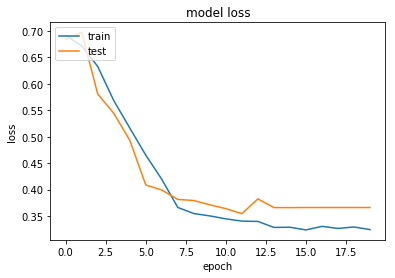

In [24]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
test_data = making_test_data()


100%|██████████| 12500/12500 [00:15<00:00, 824.34it/s]


In [26]:
with open('final.csv','w') as f:
    f.write('id,label\n')
with open('final.csv','a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(1,1,50,50)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num,model_out[1]))

100%|██████████| 12500/12500 [02:43<00:00, 76.46it/s]
